# Dataset 1 

In [3]:
from pymongo import MongoClient, collection
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen as ureq
import re
import logging

### Setting MongoDB parameters

In [4]:
client = MongoClient()
my_key = "AnqLqo5TT9JDfzfqKrDUEYUqJ6HWZJy8"
base = "https://api.mlab.com/api/1"
url_db = base + "/databases?apiKey=" + my_key
response = requests.get(url_db)
databases = json.loads(response.text)
adm_database = databases[0]
adm_database

'adm_hm4'

In [5]:
# Set structure for database
headers = {'content-type':'application/json'}

We manually created the collection 'flats' in the "adm_hm4" database (MongoDB)

In [6]:
collection = 'flats'
col_url = base + '/databases/' + adm_database + "/collections/" + collection +'/?apiKey=' + my_key

# Pushing data into database
# payload = json.dumps(flat_data)
# response = requests.post(col_url, data=payload, headers=headers)

Now, we extract the interesting data from websites and push into our database

In [7]:
def scrap_data(soup):
    """ 
    This function is retrieving data about : price, locali, superficie, bagni, piano.
    Input: The Beautiful Soup object.
    Output: The dictionary object with integer values. 
    """
    # find the html tag with price
    price = soup.find_all('li',class_='features__price')[0].get_text()
    # extract and preprocess string to get price
    price = price.replace("€", "").replace(" ", "").replace(".", "")
    # find the html tag with the info about: locali, superficie, bagni, piano
    data = soup.find_all('ul','list-inline list-piped features__list')[0].get_text()
    # preprocess string and find numbers
    data = data.replace('m2','')
    numbers = re.compile('\d+(?:\.\d+)?')
    data = numbers.findall(data)
    # if found all numbers -> return them as a dictionary
    if len(data)==4:
         return [{'price':int(price),'locali': int(data[0]), 'superficie': int(data[1]), "bagni": int(data[2]), "piano": int(data[3])}]

In [8]:
def threadExtract(url):
    """
    This function is getting html content, scrapping data and saving it into our database.
    Input: String: "url" 
    """
    logging.info('extracting' + url)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    data_dict = scrap_data(soup) #output should be a dictionary
    
    collection = 'flats'
    col_url = base + '/databases/' + adm_database + "/collections/" + collection +'/?apiKey=' + my_key

    # Pushing data into database
    payload = json.dumps(data_dict)
    response = requests.post(col_url, data=payload, headers=headers)

    logging.info("Done extracting")

#### Thread-based parallelism :

In [ ]:
links=[] # list with links used while retrieving data

stop = False
i = 1 
while stop == False:
    # Loading the initial web-page
    content = requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i))
    soup = BeautifulSoup(content.text, 'html.parser')
    
    # Scrapping data from each link from the initial website until we get 10000 links
    for link in soup.find_all('a', href=True):
        url = link['href']
        if url.startswith('https://www.immobiliare.it/') and url.endswith('.html'):
            try:
                threadExtract(url)
                links.append(url)
                if len(links >= 10000): stop = True
            except: continue
    i += 1

In [9]:
# display what is inside the database
response = requests.get(col_url)
result = json.loads(response.text)
result

[{'_id': {'$oid': '5c00185f5d0e6536bebf4b59'},
  'bagni': 1,
  'locali': 2,
  'piano': 1,
  'price': 225000,
  'superficie': 50},
 {'_id': {'$oid': '5c0018605d0e6536bebf4b5e'},
  'bagni': 2,
  'locali': 4,
  'piano': 2,
  'price': 1350000,
  'superficie': 200},
 {'_id': {'$oid': '5c0018631f6e4f34a8bab53a'},
  'bagni': 1,
  'locali': 2,
  'piano': 5,
  'price': 135000,
  'superficie': 60},
 {'_id': {'$oid': '5c0018665d0e6536bebf4b5f'},
  'bagni': 1,
  'locali': 2,
  'piano': 1,
  'price': 249000,
  'superficie': 75},
 {'_id': {'$oid': '5c0018695d0e6536bebf4b63'},
  'bagni': 1,
  'locali': 2,
  'piano': 3,
  'price': 339000,
  'superficie': 70},
 {'_id': {'$oid': '5c00186f1f6e4f34a8bab545'},
  'bagni': 1,
  'locali': 3,
  'piano': 1,
  'price': 215000,
  'superficie': 67},
 {'_id': {'$oid': '5c0018725d0e6536bebf4b65'},
  'bagni': 1,
  'locali': 3,
  'piano': 4,
  'price': 339000,
  'superficie': 90},
 {'_id': {'$oid': '5c0018731f6e4f34a8bab548'},
  'bagni': 3,
  'locali': 5,
  'piano': 5

In [10]:
import numpy as np

# Convert data into matrix
dataset1 = np.matrix(list(map(lambda x:list(x.values())[1:], result)))

In [11]:
len(dataset1) #number of rows

364

In [38]:
dataset11 = pd.DataFrame(result)
dataset11 = dataset11.drop(columns=['_id'])
dataset11.head()

,bagni,locali,piano,price,superficie
0,1,2,1,225000,50
1,2,4,2,1350000,200
2,1,2,5,135000,60
3,1,2,1,249000,75
4,1,2,3,339000,70


In [12]:
dataset1

matrix([[ 225000,       2,      50,       1,       1],
        [1350000,       4,     200,       2,       2],
        [ 135000,       2,      60,       1,       5],
        ...,
        [ 179000,       3,      81,       1,       3],
        [ 255000,       3,      95,       2,       2],
        [ 400000,       4,     120,       1,       2]])

**K-MEANS ++ **

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

In [51]:
sse = {}
for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k, max_iter=1000).fit(dataset11)
    dataset11['clusters'] = kmeanModel.labels_
    sse[k] = kmeanModel.inertia_ # check it

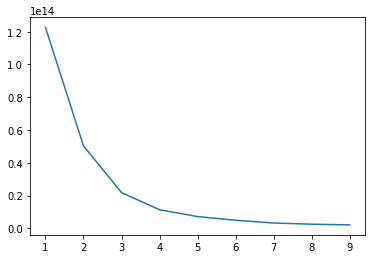

In [57]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel = "k - Number of clusters "  # Why we do not have titles? 
plt.ylabel = "SSE (Inertia)"
plt.title = "Plot of SSE for kmeans clustering"
plt.show()

According to the plot, we think that the best number of clusters can be 5.

In [60]:
kmeanModel = KMeans(n_clusters=5, max_iter=1000).fit(dataset11)
dataset11['information_clusters'] = kmeanModel.labels_

In [61]:
dataset11.head()

,bagni,locali,piano,price,superficie,clusters,information_clusters
0,1,2,1,225000,50,0,1
1,2,4,2,1350000,200,3,4
2,1,2,5,135000,60,0,1
3,1,2,1,249000,75,0,1
4,1,2,3,339000,70,0,1


In [68]:
#### Test for JAccard Similarity

In [64]:
import random

In [66]:
dataset11['description_clusters'] = [random.randint(0, 5) for i in range(364)]

In [67]:
dataset11.head()

,bagni,locali,piano,price,superficie,clusters,information_clusters,description_clusters
0,1,2,1,225000,50,0,1,0
1,2,4,2,1350000,200,3,4,0
2,1,2,5,135000,60,0,1,3
3,1,2,1,249000,75,0,1,5
4,1,2,3,339000,70,0,1,2


In [72]:
from  sklearn.metrics import jaccard_similarity_score
jaccard_sim = round(jaccard_similarity_score(kmeanModel.labels_, [random.randint(0, 5) for i in range(364)]), 2)
jaccard_sim

0.19